# Compare the harmonized AVHRR with Landsat

Using monthly median DEA Landsat 5 & 7 surface relectance NBAR, 1988-2010

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import scipy.signal
import xskillscore as xs
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from odc.geo.xr import assign_crs
from matplotlib.ticker import FormatStrFormatter
from xarrayMannKendall import Mann_Kendall_test

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [3]:
ls = xr.open_dataset(base+'/NDVI_harmonization/Landsat_NDVI_5km_monthly_1988_2012.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

# trees = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
# nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
# merge = xr.where(np.isnan(trees), nontrees, trees)
# merge = assign_crs(merge, crs=crs)
# merge.attrs['nodata'] = np.nan
# merge = merge.rename('NDVI')

# merge = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_wGaps.nc')['NDVI']
merge = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc')['NDVI']
merge = assign_crs(merge, crs=crs)
merge.attrs['nodata'] = np.nan
merge = merge.rename('NDVI')

syn = xr.open_dataset(f'{base}/synthetic/NDVI/NDVI_CLIM_synthetic_5km_monthly_1982_2022.nc')['NDVI']
syn = assign_crs(syn, crs=crs)
syn.attrs['nodata'] = np.nan
syn = syn.rename('NDVI')

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis.attrs['nodata'] = np.nan

merge = merge.rename({'latitude':'y', 'longitude':'x'})
ls = ls.rename({'latitude':'y', 'longitude':'x'})
modis = modis.rename({'latitude':'y', 'longitude':'x'})
syn = syn.rename({'latitude':'y', 'longitude':'x'})

## Match datasets

In [4]:
merge = merge.sel(time=ls.time)
modis = modis.sel(time=slice('2001', '2012'))
syn = syn.sel(time=ls.time)

avhrr_mask =  ~np.isnan(merge)
del avhrr_mask.attrs['nodata']
avhrr_mask = assign_crs(avhrr_mask, crs=crs)

ls_mask =  ~np.isnan(ls)
del ls_mask.attrs['nodata']
ls_mask = assign_crs(ls_mask, crs=crs)

ls = ls.where(avhrr_mask)
merge = merge.where(ls_mask)

modis = modis.where(ls_mask)
modis = modis.where(avhrr_mask)

syn = syn.where(ls_mask)
syn = syn.where(avhrr_mask)

In [5]:
# ls.sel(time='2000').plot.imshow(col='time', col_wrap=4)

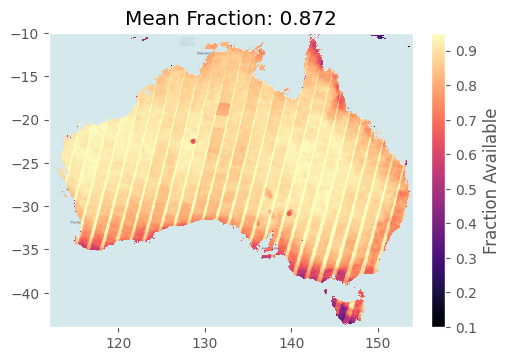

In [6]:
fraction_avail_ls = (~np.isnan(ls)).sum('time')/len(ls.time)
fraction_avail_merge = (~np.isnan(merge)).sum('time')/len(merge.time)

fig,ax=plt.subplots(1,1, figsize=(5,4),sharey=True, layout='constrained')

im = fraction_avail_ls.where(fraction_avail_ls>0).rename('').plot(vmin=0.1, vmax=0.95, ax=ax, cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cb = fig.colorbar(im, ax=ax, shrink=0.75, orientation='vertical', label='Fraction Available');
ax.set_title('Mean Fraction: '+str(round(fraction_avail_ls.where(fraction_avail_ls>0).mean().values.item(), 3)));

### Timeseries plots


#### per region

In [7]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


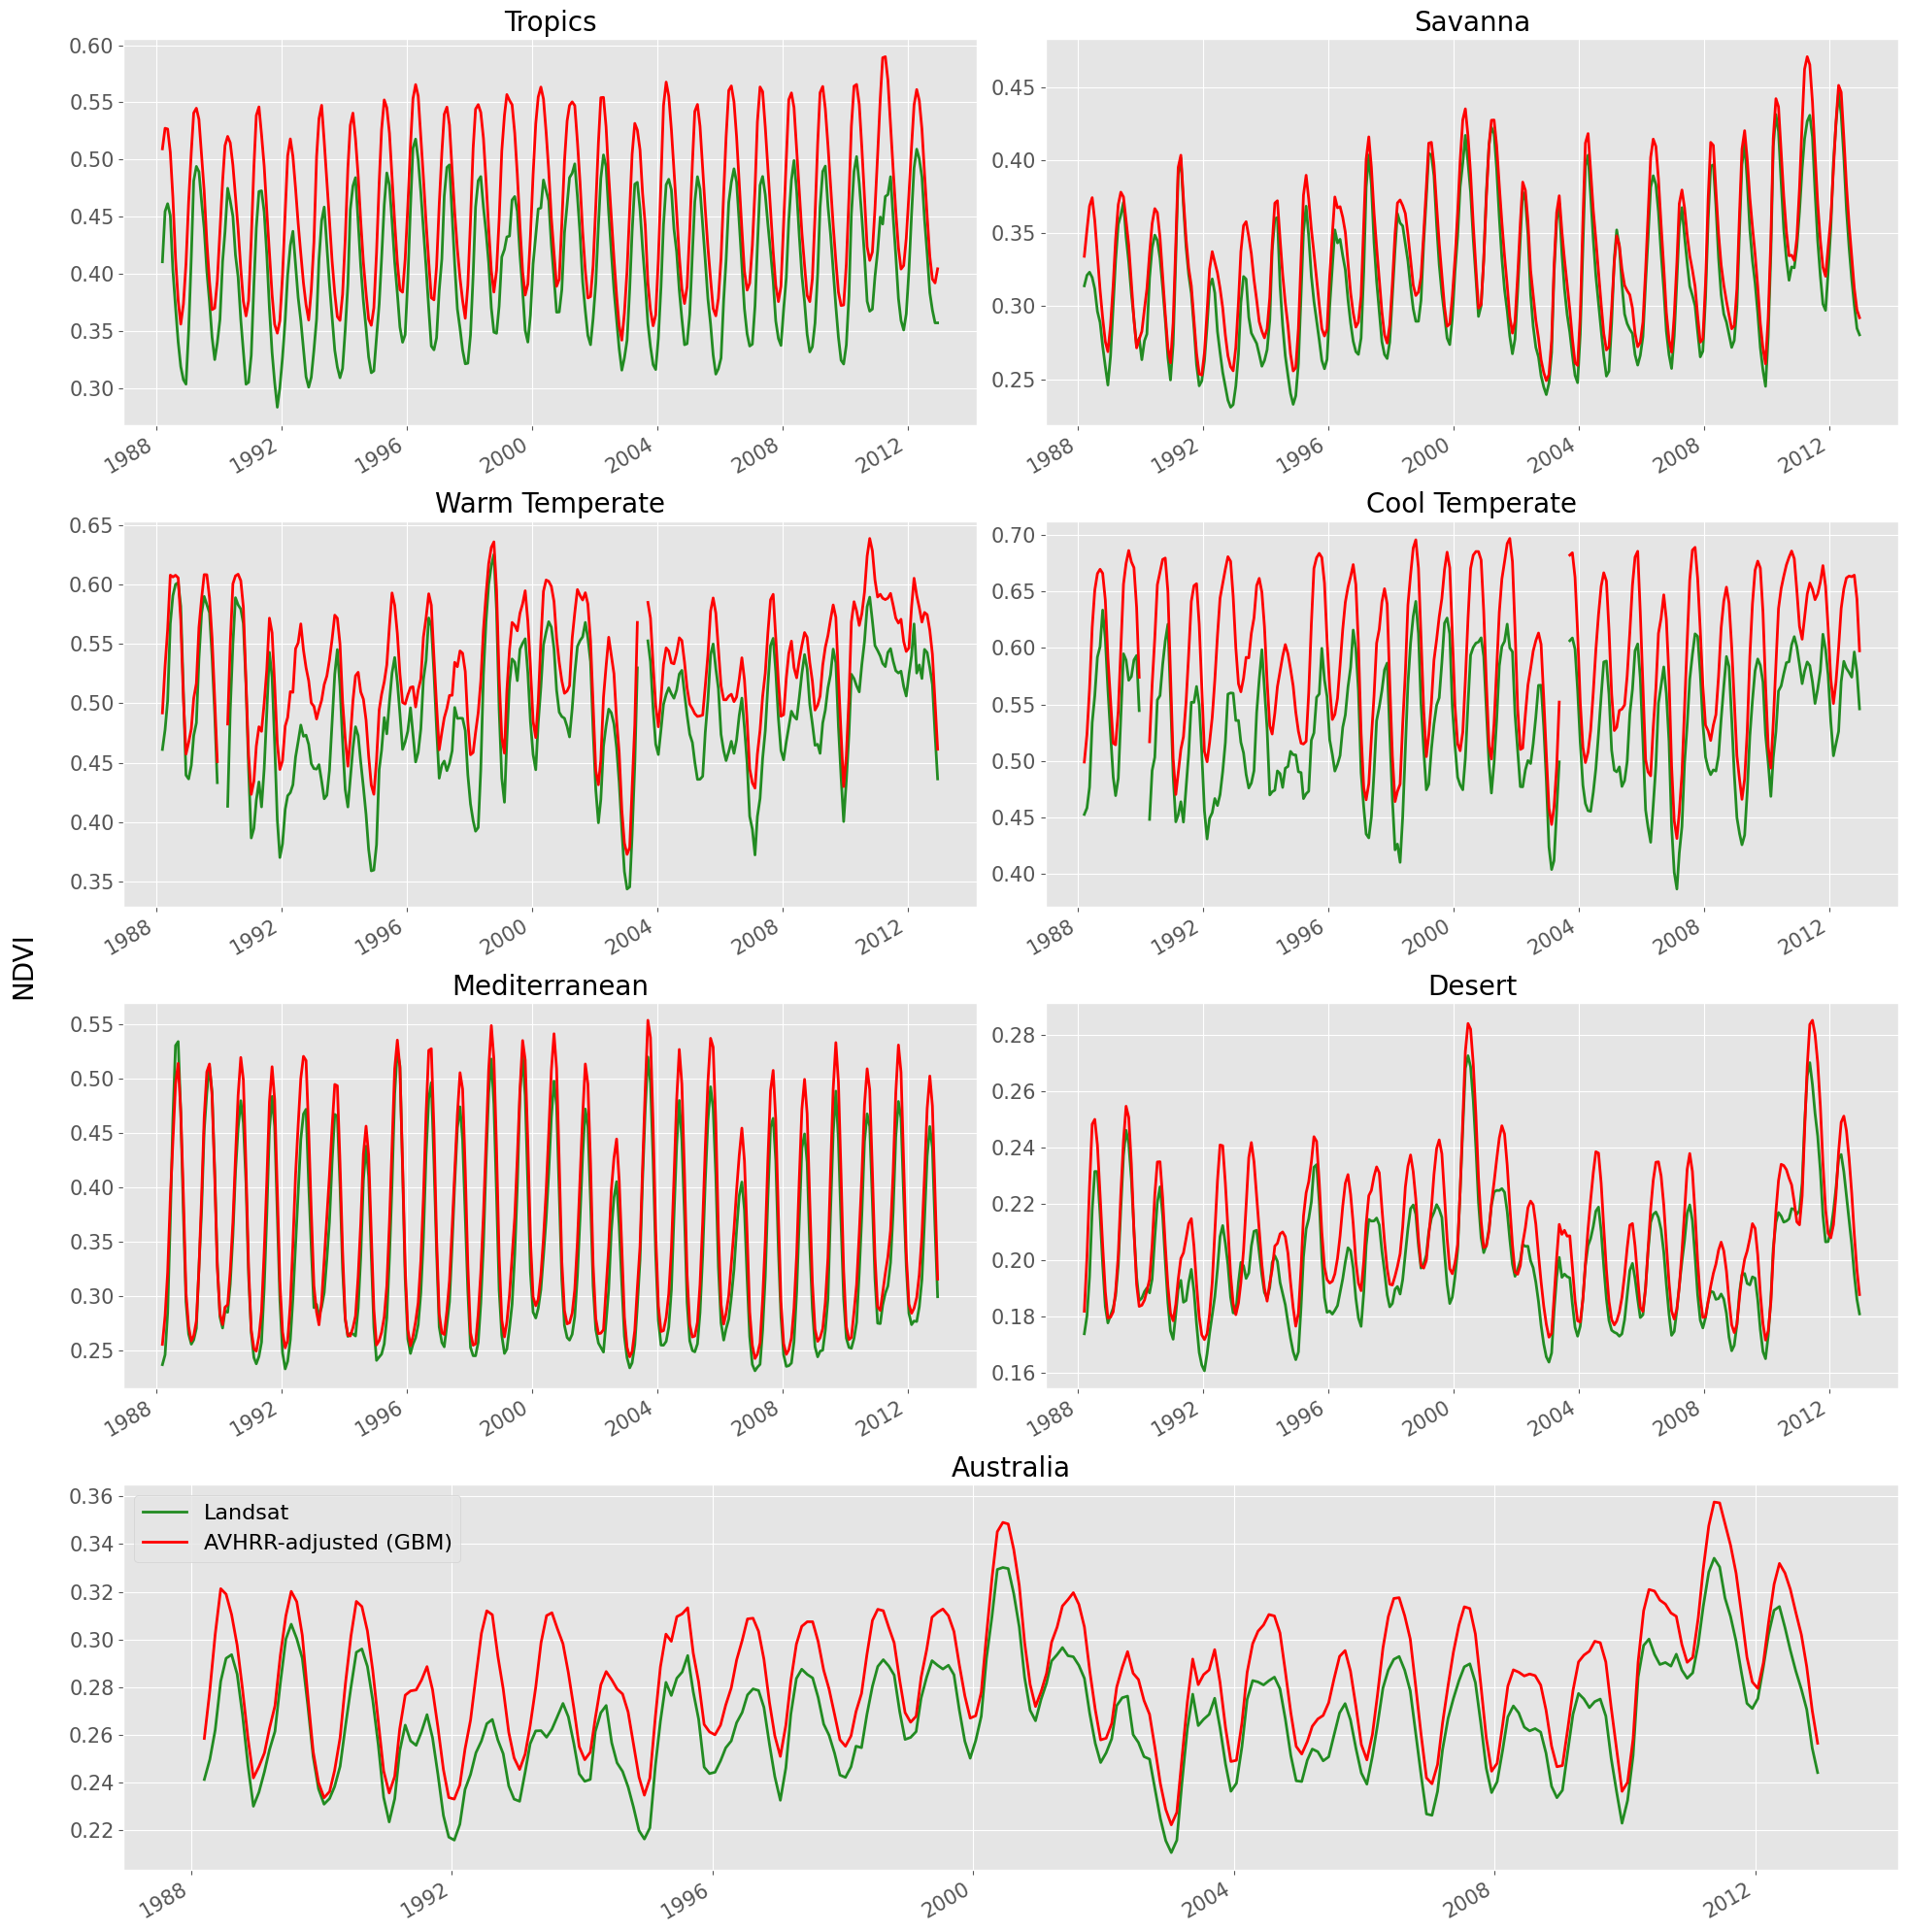

In [8]:
plt.style.use('ggplot')
mosiac = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "G"],
]

fig, axes = plt.subplot_mosaic(mosiac, figsize=(20,20))

for ax, (index, row) in zip(axes, gdf.iterrows()):
    print(row['region_name'])
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ls, crs=crs)
    mask = mask.rename({'latitude':'y', 'longitude':'x'})
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ls_region = ls.where(mask)
    merge_region = merge.where(mask)
    modis_region = modis.where(mask)
    # syn_region = syn.where(mask)

    ls_region.mean(['x','y']).rolling(time=3).mean().plot(ax=axes[ax], label='Landsat', c ='forestgreen', linewidth=2)
    merge_region.mean(['x','y']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR-adjusted (GBM)', c='red', linewidth=2)
    # modis_region.mean(['x','y']).rolling(time=3).mean().plot(ax=axes[ax], label='MODIS', c='blue', linewidth=2)
    # syn_region.mean(['x','y']).rolling(time=3).mean().plot(ax=axes[ax], label='Synthetic', c='orange', linewidth=2)
    
    axes[ax].set_ylabel('')
    axes[ax].set_xlabel('')
    # axes[ax].sharex(axes['E'])
    axes[ax].tick_params(axis='y', labelsize=15)
    axes[ax].tick_params(axis='x', labelsize=15)
    axes[ax].set_title(row['region_name'], fontsize=20)
    axes[ax].grid(True)

#the last Aus-wide plot
ls.mean(['x','y']).rolling(time=3).mean().plot(ax=axes['G'], label='Landsat', c ='forestgreen', linewidth=2)
merge.mean(['x','y']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-adjusted (GBM)', c='red', linewidth=2)
# modis.mean(['x','y']).rolling(time=3).mean().plot(ax=axes['G'], label='MODIS', c='blue', linewidth=2)
# syn.mean(['x','y']).rolling(time=3).mean().plot(ax=axes['G'], label='Synthetic', c='orange', linewidth=2)

axes['G'].set_title('Australia', fontsize=20)
axes['G'].legend(fontsize=16)
axes['G'].set_ylabel('')
axes['G'].set_xlabel('')
axes['G'].tick_params(axis='y', labelsize=15)
axes['G'].tick_params(axis='x', labelsize=15)
axes['G'].grid(True)

fig.supylabel(model_var, fontsize=20)    
plt.tight_layout(rect=(0.015,0,1,1))
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_landsat_timeseries_bioregion.png',
            bbox_inches='tight', dpi=300);

In [ ]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.groupby("time.month").mean(),
            ds.groupby("time.month").std()
    )
    
rain_std_anom = stand_anomalies(rain)
merge_std_anom = stand_anomalies(merge)
ls_std_anom = stand_anomalies(ls)
syn_std_anom = stand_anomalies(syn)

In [34]:
roll=12

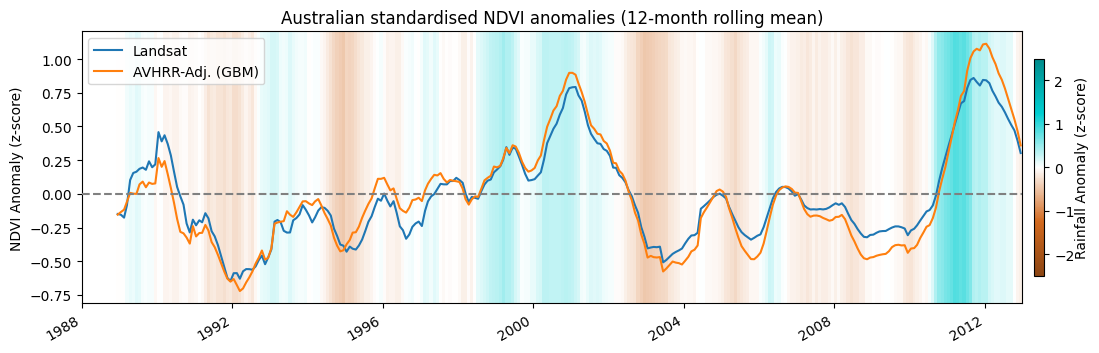

In [35]:
rain_df = rain_std_anom.rename('rain').rolling(time=roll,
                min_periods=roll).mean().mean(['latitude','longitude']).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()

# syn_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='Synthetic')
ls_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='Landsat')
merge_std_anom.drop('month').rolling(time=roll, min_periods=roll).mean().mean(['x','y']).plot(ax=ax, label='AVHRR-Adj. (GBM)')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)

ax.legend()
ax.set_title('Australian standardised NDVI anomalies ('+str(roll)+'-month rolling mean)');
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/NDVI_rolling_anomalies_compare_landsat_"+str(roll)+"Mrollingmean.png",
            bbox_inches='tight', dpi=300)

### Per-pixel error metrics

In [11]:
merge_mean = merge.mean('time')
low_ndvi_mask = xr.where(merge_mean<0.10,0, 1)

In [12]:
orig_corr = xr.corr(merge, ls, dim='time')
orig_corr = orig_corr.where(low_ndvi_mask)

orig_rmse = xs.rmse(merge, ls, dim='time', skipna=True)
orig_rmse = orig_rmse.where(low_ndvi_mask)

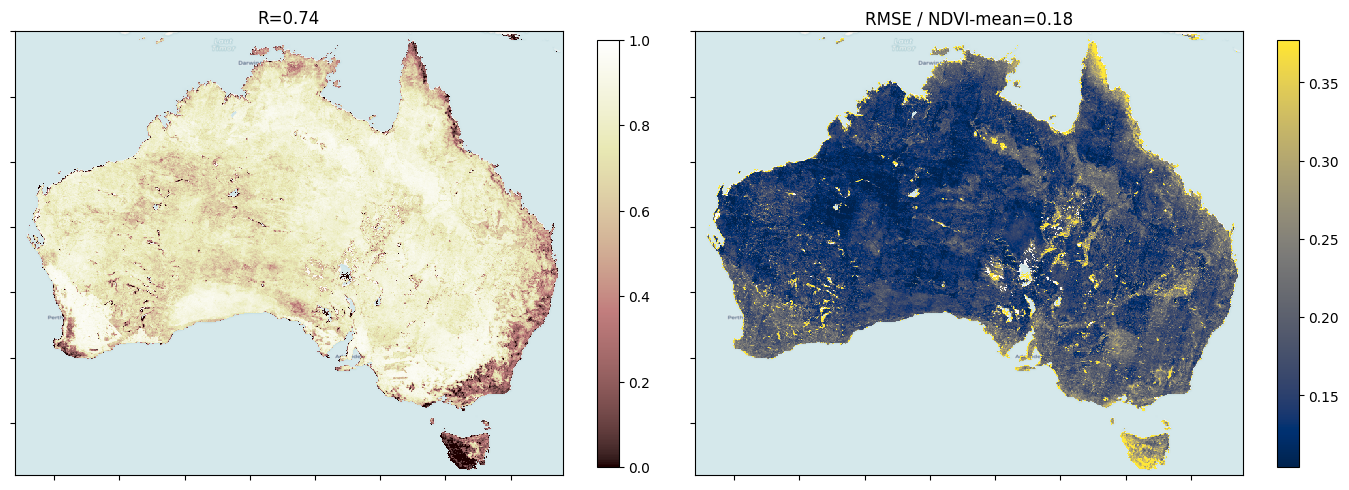

In [13]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
im = orig_corr.plot(vmin=0, vmax=1, cmap='pink', ax=ax[0], add_colorbar=False)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cb = fig.colorbar(im, ax=ax[0], shrink=0.75, orientation='vertical');
ax[0].set_title(f'R='"{:.2f}".format(orig_corr.mean().values))
ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

im = (orig_rmse / merge_mean).plot(robust=True, cmap='cividis', ax=ax[1], add_colorbar=False)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
cb = fig.colorbar(im, ax=ax[1], shrink=0.75, orientation='vertical');
ax[1].set_title(f'RMSE / NDVI-mean='"{:.2f}".format( (orig_rmse / merge_mean).mean().values))
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_xticklabels([]);

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_Landsat_perpixel.png',
            bbox_inches='tight', dpi=300);

## Residuals through time



In [14]:
#residuals after harmonization
residual = (ls - merge).mean(['x', 'y']).drop('spatial_ref').to_dataframe(name='Landsat residuals')
residual_sd = (ls - merge).std(['x', 'y']).drop('spatial_ref').to_dataframe(name='Landsat residuals')

residual_syn = (ls - syn).mean(['x', 'y']).drop('spatial_ref').to_dataframe(name='Synthetic residuals')

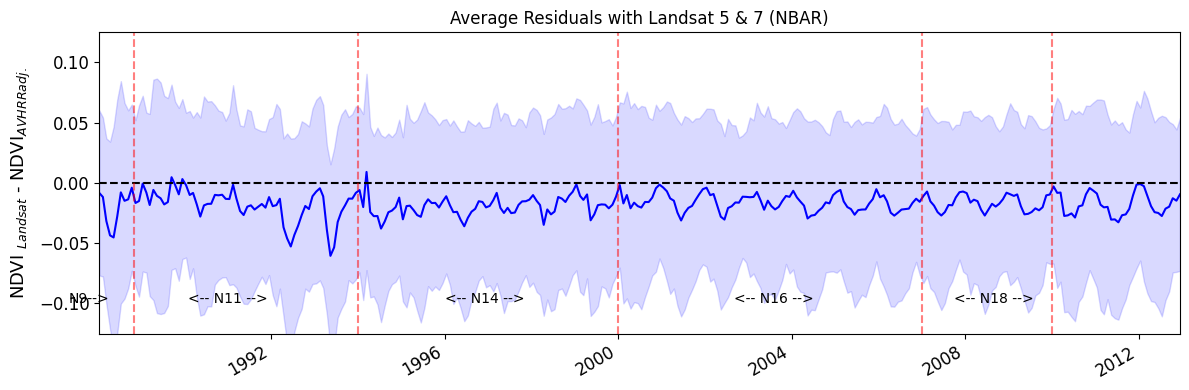

In [15]:
fig,ax = plt.subplots(1,1, figsize=(12,4), sharex=True)

residual.plot(ax=ax, legend=False, color='blue')
ax.fill_between(residual.index, (residual-residual_sd)['Landsat residuals'],
                (residual+residual_sd)['Landsat residuals'], alpha=0.15, color='blue')

# residual_syn.plot(ax=ax, legend=False, color='forestgreen')

ax.axhline(0.0, color='k', linestyle='--')
# ax.legend(loc='upper left')
ax.set_title('Average Residuals with Landsat 5 & 7 (NBAR)')
ax.set_ylim(-0.125, 0.125)
ax.set_ylabel(model_var+" $_{Landsat}$"+ " - "+model_var+"$_{AVHRR adj.}$", fontsize=13)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.margins(x=0)

ax.axvline('1988-11', color='red', linestyle='--', alpha=0.5)
plt.text('1987-05',-0.1,'N9-->',rotation=0)

ax.axvline('1994', color='red', linestyle='--', alpha=0.5)
plt.text('1990-02',-0.1,'<-- N11 -->',rotation=0)

ax.axvline('2000', color='red', linestyle='--', alpha=0.5)
plt.text('1996',-0.1,'<-- N14 -->',rotation=0)

ax.axvline('2007', color='red', linestyle='--', alpha=0.5)
plt.text('2002-09',-0.1,'<-- N16 -->',rotation=0)

ax.axvline('2010', color='red', linestyle='--', alpha=0.5)
plt.text('2007-10',-0.1,'<-- N18 -->',rotation=0)

plt.tight_layout()
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_Landsat_residuals.png',
            bbox_inches='tight', dpi=300);

## Compare phenology trends

### Smoothing filters

In [16]:
# rolling means
ls_smooth = ls.rolling(time=3, center=True, min_periods=1).mean()
merge_smooth = merge.rolling(time=3, center=True, min_periods=1).mean()

#SG cuts of last 6 months so clip to complete calendar years.
ls_smooth = ls_smooth.sel(time=slice('1982', '2021'))
merge_smooth = merge_smooth.sel(time=slice('1982', '2021'))

# #increase temporal res.
ls_smooth = ls_smooth.resample(time="2W").interpolate("linear")
merge_smooth = merge_smooth.resample(time="2W").interpolate("linear")

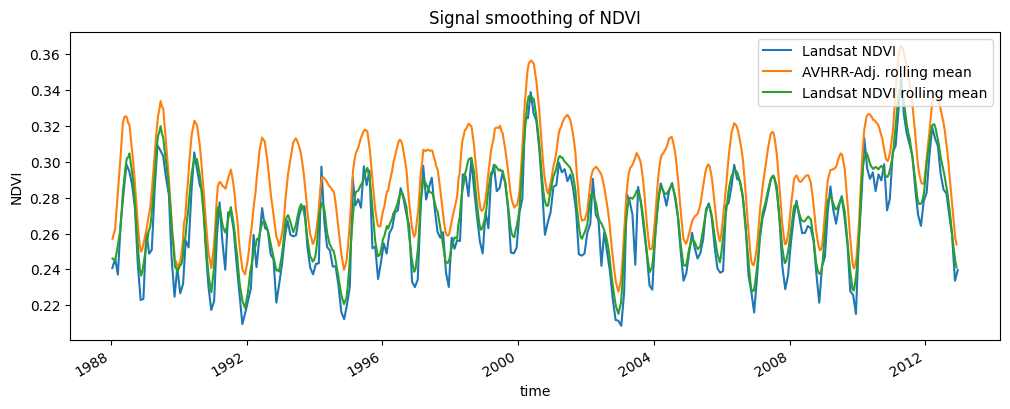

In [17]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
ls.mean(['x', 'y']).plot(ax=ax, label='Landsat NDVI')
merge_smooth.mean(['x', 'y']).plot(ax=ax, label='AVHRR-Adj. rolling mean')
ls_smooth.mean(['x', 'y']).plot(ax=ax, label='Landsat NDVI rolling mean')

ax.legend(loc='upper right')
ax.set_title('Signal smoothing of NDVI');

### Phenology

In [18]:
import warnings
warnings.simplefilter('ignore')
ls_doy = ls_smooth.groupby('time.year').map(xr_phenology)
merge_doy = merge_smooth.groupby('time.year').map(xr_phenology)

Text(0.5, 1.0, '')

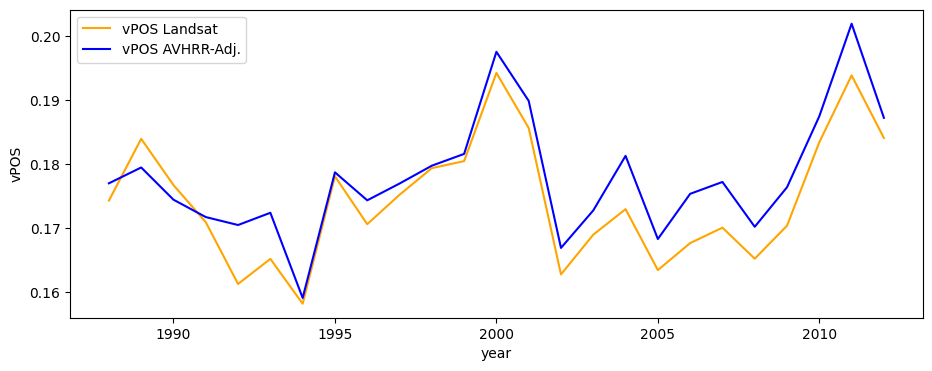

In [19]:
fig,ax=plt.subplots(1,1, figsize=(11,4))
# ax2 = ax.twinx()
ls_doy.vPOS.mean(['x', 'y']).plot(ax=ax, c='orange', label='vPOS Landsat')
merge_doy.vPOS.mean(['x', 'y']).plot(ax=ax, c='blue', label='vPOS AVHRR-Adj.')
# doy.AOS.where(doy.AOS>0).mean(['x', 'y']).plot(ax=ax2, label='AOS NDVI')
# doy.Trough.where(doy.AOS>0).mean(['x', 'y']).plot(ax=ax2, label='AOS NDVI')
ax.legend(loc='upper left')
# ax2.legend(loc='upper right')
ax.set_title('')
# ax2.set_title('Australia-wide trends in Peak-Of-Season NDVI');

### Per pixel trends in POS

Use the Mann-Kendall robust regression (this is quite slow)

In [20]:
ls_pos_trends = Mann_Kendall_test(ls_doy['POS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

ls_vpos_trends = Mann_Kendall_test(ls_doy['vPOS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

merge_pos_trends = Mann_Kendall_test(merge_doy['POS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

merge_vpos_trends = Mann_Kendall_test(merge_doy['vPOS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

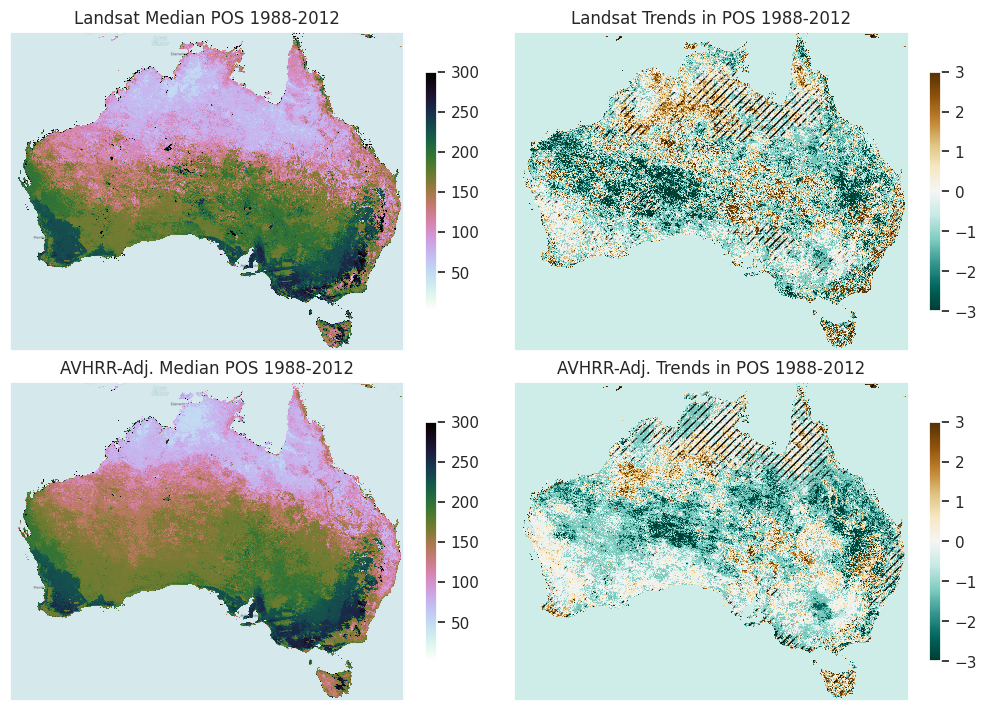

In [21]:
sb.set(font_scale=1.0)
vmin=1
vmax=300
font=12

fig,ax = plt.subplots(2,2, figsize=(10,7), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,4)):
    if i==0:
        im = ls_doy['POS'].where(ls_doy['POS']>20).median('year').plot(cmap='cubehelix_r',
                                                vmin=vmin, vmax=vmax,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('Landsat Median POS 1988-2012', fontsize=font)
    
    if i==1:
        t = ls_pos_trends.trend.where((ls_pos_trends.trend>-0.02) | (ls_pos_trends.trend<-0.03))
        im = t.plot(vmin=-3, vmax=3, ax=a, add_labels=False, cmap='BrBG_r', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(ls_vpos_trends.trend.where(ls_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('Landsat Trends in POS 1988-2012', fontsize=font)

    if i==2:
        im = merge_doy['POS'].where(merge_doy['POS']>20).median('year').plot(cmap='cubehelix_r',
                                                        vmin=vmin, vmax=vmax,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('AVHRR-Adj. Median POS 1988-2012', fontsize=font)
    
    if i==3:
        t = merge_pos_trends.trend.where((merge_pos_trends.trend>-0.02) | (merge_pos_trends.trend<-0.03))
        im = t.plot(vmin=-3, vmax=3, ax=a, add_labels=False, cmap='BrBG_r', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(merge_vpos_trends.trend.where(merge_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('AVHRR-Adj. Trends in POS 1988-2012', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_NDVI_compare_landsat_perpixel_trends.png",
            bbox_inches='tight', dpi=300)


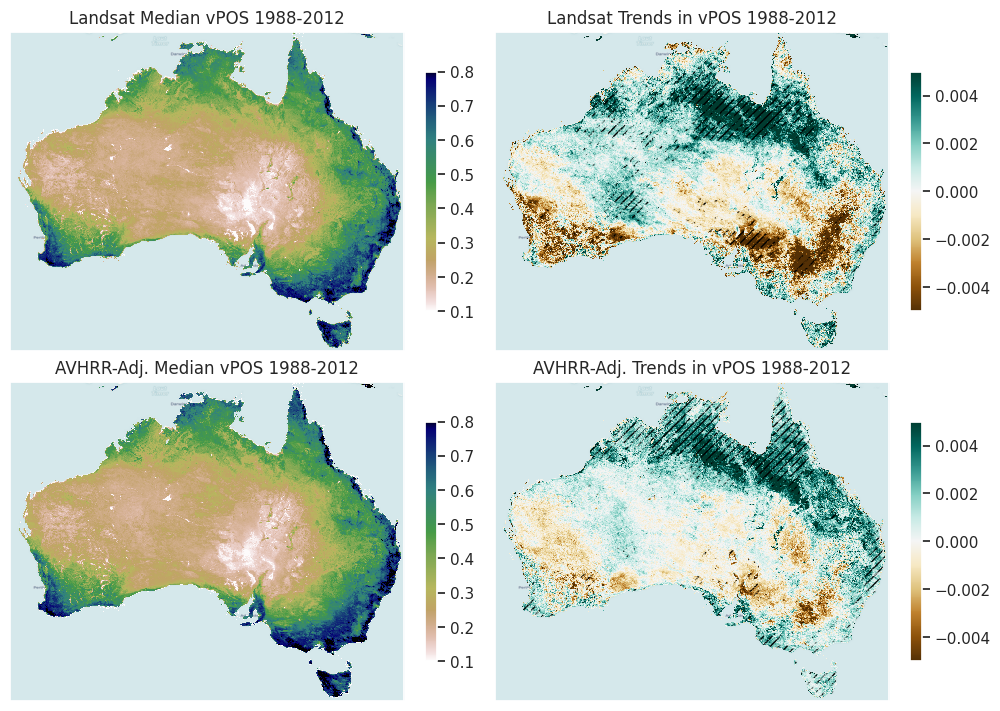

In [22]:
sb.set(font_scale=1.0)
fig,ax = plt.subplots(2,2, figsize=(10,7), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,4)):
    if i==0:
        m = ls_doy['vPOS'].median('year')
        im = m.where(m>0).plot(cmap='gist_earth_r', vmin=0.1, vmax=0.8,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('Landsat Median vPOS 1988-2012', fontsize=font)
    
    if i==1:
        im = ls_vpos_trends.trend.where(ls_vpos_trends.trend!=0).plot(vmin=-0.005, vmax=0.005, ax=a, add_labels=False, cmap='BrBG', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(ls_vpos_trends.trend.where(ls_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('Landsat Trends in vPOS 1988-2012', fontsize=font)

    if i==2:
        m = merge_doy['vPOS'].median('year')
        im = m.where(m>0).plot(cmap='gist_earth_r', vmin=0.1, vmax=0.8,ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        a.set_title('AVHRR-Adj. Median vPOS 1988-2012', fontsize=font)
    
    if i==3:
        im = merge_vpos_trends.trend.where(merge_vpos_trends.trend!=0).plot(vmin=-0.005, vmax=0.005, ax=a, add_labels=False, cmap='BrBG', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.75, orientation='vertical', label='')
        xr.plot.contourf(merge_vpos_trends.trend.where(merge_vpos_trends.signif), ax=a, alpha=0, hatches=['////'], add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('AVHRR-Adj. Trends in vPOS 1988-2012', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_NDVI_compare_landsat_perpixel_trends.png",
            bbox_inches='tight', dpi=300)

### Trends in POS & vPOS etc. disaggregrated by bioclimatic region


In [23]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [24]:
doy_var = [ls_pos_trends, ls_vpos_trends, merge_pos_trends, merge_vpos_trends]
names = ['Landsat_POS', 'Landsat_vPOS', 'AVHRR-Adj._POS', 'AVHRR-Adj._vPOS']

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ls.isel(time=1))
    mask = round_coords(mask)
    
    mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(doy_var, names):
        var_region = v.where(mask)
        
        doy_df = var_region.drop('spatial_ref').to_dataframe()
        doy_df = doy_df[['trend', 'signif']]
        
        doy_df['region'] = row['region_name']
        doy_df = doy_df.rename({
            'trend':'trend_'+n,
            'signif':'signif_'+n,
                      }, axis=1)
        inner.append(doy_df)
    outer.append(inner)

trends_df=[]
for i in range(0,len(outer)):
    xx = trends_df.append(pd.concat(outer[i]))
trends_df = pd.concat(trends_df).reset_index(drop=True)

### POS

Landsat

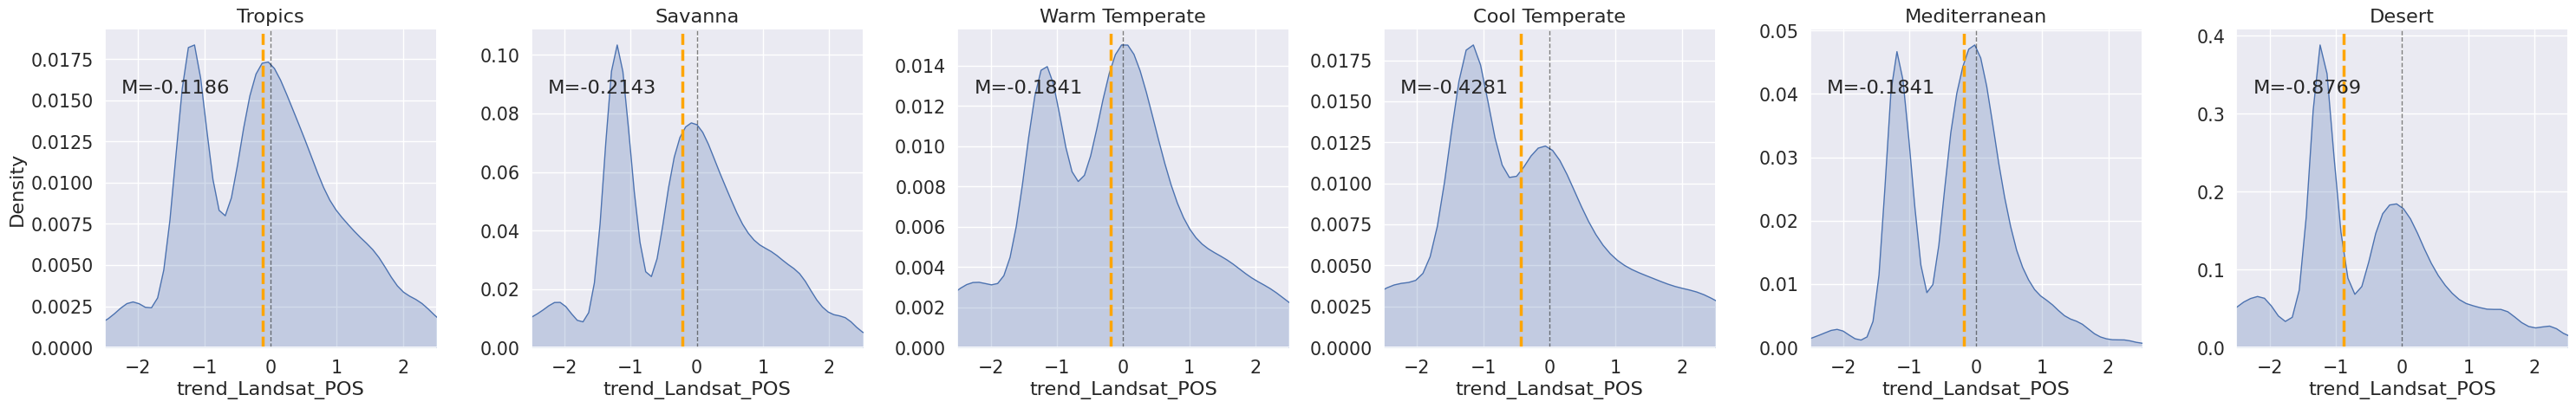

In [25]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_Landsat_POS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-2.5,2.5))
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_Landsat_POS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_NDVI_landsat_bioregion_dist_1988_2012.png",
          bbox_inches='tight', dpi=300);

AVHRR-adj.

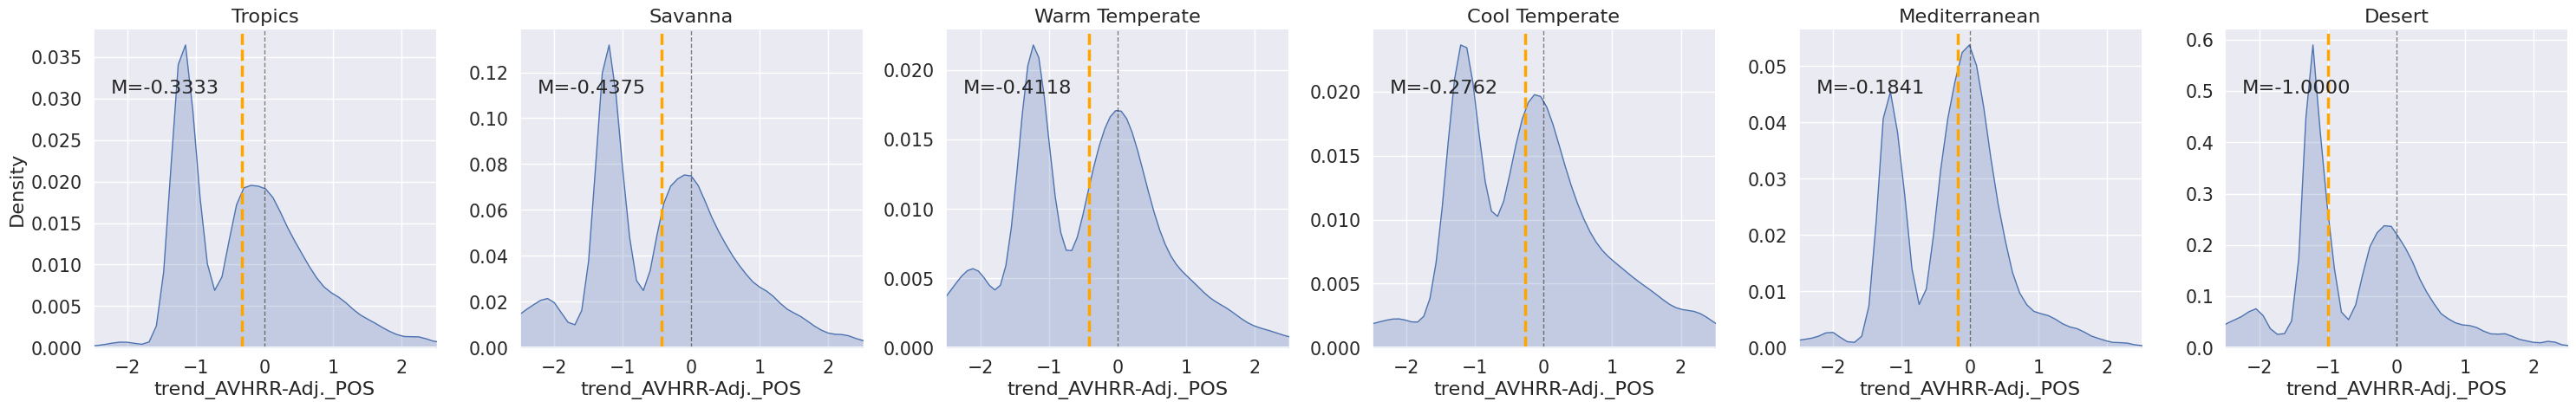

In [26]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_AVHRR-Adj._POS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-2.5,2.5))
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_AVHRR-Adj._POS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/POS_NDVI_AVHRR-Adj._bioregion_dist_1988_2012.png",
          bbox_inches='tight', dpi=300);

### vPOS

Landsat

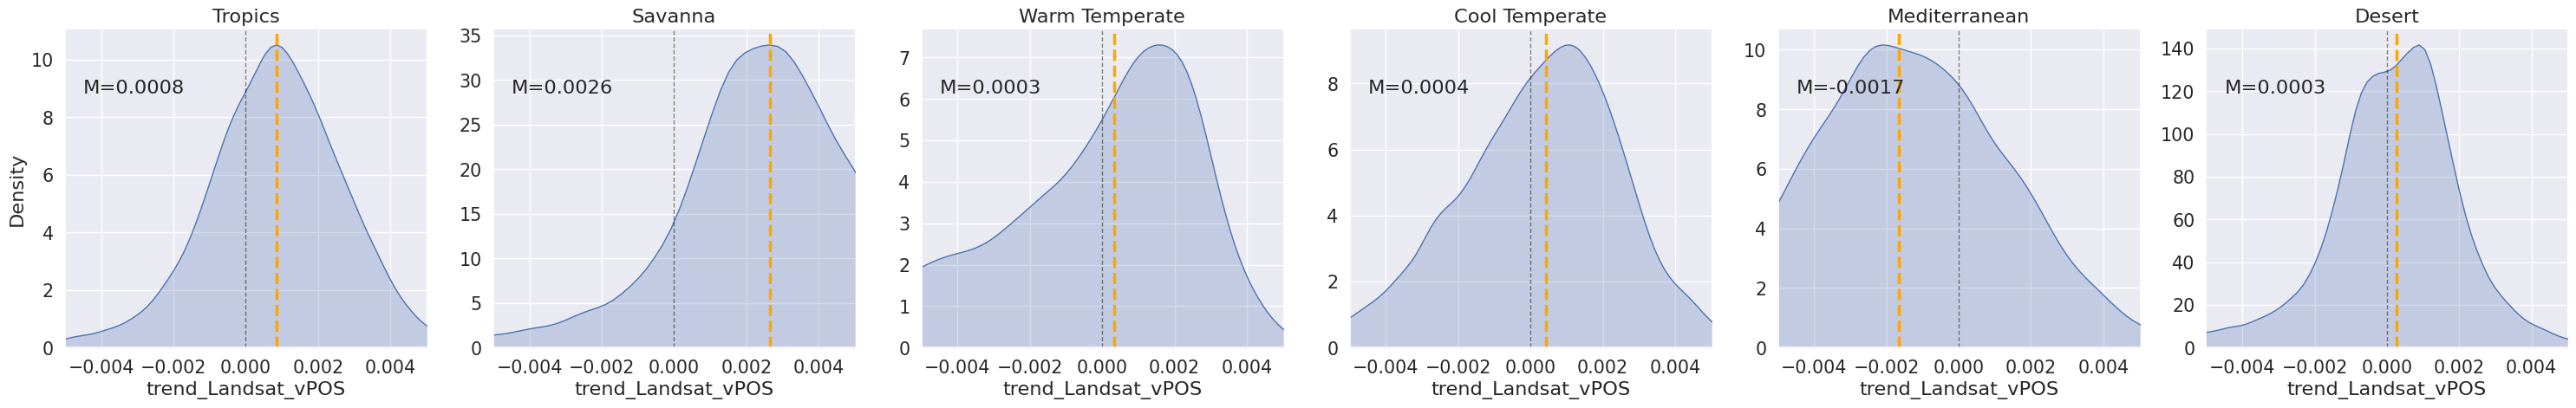

In [27]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_Landsat_vPOS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-0.005, 0.005))
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_Landsat_vPOS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_NDVI_landsat_bioregion_dist_1988_2012.png",
          bbox_inches='tight', dpi=300);

AVHRR-Adj.

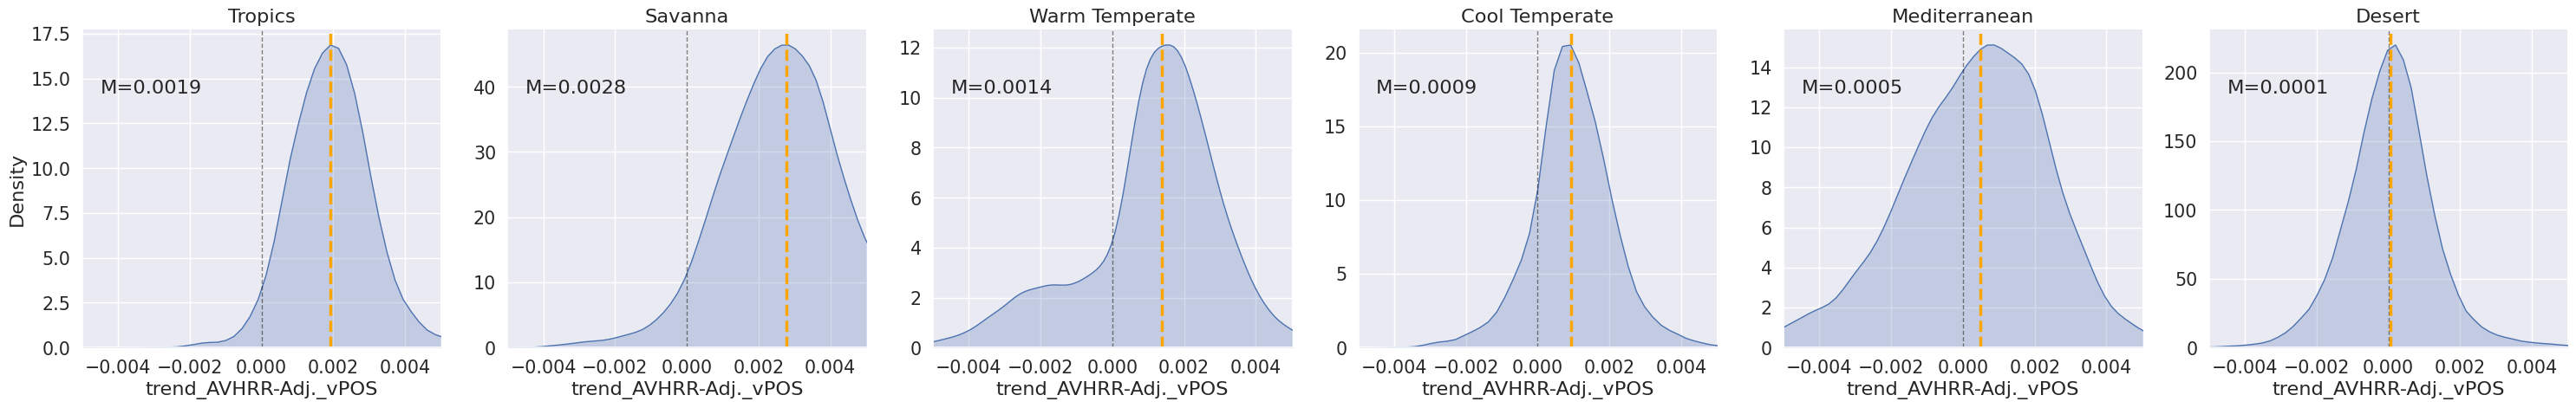

In [28]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_AVHRR-Adj._vPOS",
    col="region", col_wrap=6, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-0.005, 0.005))
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_AVHRR-Adj._vPOS")
g.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/vPOS_NDVI_AVHRR-Adj._bioregion_dist_1988_2012.png",
          bbox_inches='tight', dpi=300);